# Parallelizing whole PhotochemPy runs

PhotochemPy is a multithreaded program. When integrating to photochemical equilibium (i.e. `pc.integrate()` function), during each timestep, calculations are distributed to all the processors on your computer. This speeds up any single integration.

But often times, people might be interested in running many photochemical integrations, each with different inputs or boundary conditions. For example, you might be interested in the surface methane flux required to sustain several different surface methane mixing ratios. In a scenario like this, it might be most useful/quick to do each integration in parallel, instead of doings sequential runs that are each multithreaded.

This tutorial shows how to do parallel photochemical integrations using the `multiprocessing` Python module.

**First**, you should close this notebook, and in the same terminal run `export OMP_NUM_THREADS=1`. Then re-open this notebook using the same terminal. This turns off multithreading in PhotochemPy, which will speed up whole parallel runs. 

Next, import some modules:

In [6]:
from PhotochemPy import PhotochemPy # Import PhotochemPy
from pathos.multiprocessing import ProcessingPool as Pool
from matplotlib import pyplot as plt
import numpy as np

Next, lets load input files to initialize a PhotochemPy object. Here I use the Archean+Haze template.

In [7]:
pc = PhotochemPy('../input/templates/Archean+haze/species.dat', \
                 '../input/templates/Archean+haze/reactions.rx', \
                 '../input/templates/Archean+haze/planet.dat', \
                 '../input/templates/Archean+haze/input_photchem.dat', \
                 '../input/templates/Archean+haze/atmosphere.txt', \
                 '../input/templates/Archean+haze/Sun_2.7Ga.txt')

Now, we need to write a python function which we want to execute in parallel. 

The function below, `wrapper`, takes in `fCH4`. It then changes the surface mixing ratio (`pc.set_mr('CH4',fCH4)`), then integrates to photochemical equilibrium (`pc.integrate()`). Finally, if the model converged, the functon outputs the Methane surface flux required to maintain the mixing ratio `fCH4`. IF the model doesn't converge, then the function outputs a `NaN`.

In [8]:
def wrapper(fCH4):
    pc.set_mr('CH4',fCH4)
    converged = pc.integrate(method="Backward_Euler",nsteps = 1500)
    if not converged:
        return np.nan
    return pc.surf_flux()['CH4']

Now we are set to do many parallel integrations:

In [4]:
fCH4 = np.logspace(-9,-2,10)

num_processes = 6 # my computer has 6 cores. So I use 6 processes

with Pool(num_processes) as p:
    PhiCH4 = p.map(wrapper, fCH4)

`multiprocessing.Pool` generates a specified number of completely independent processes. For more details about multiprocessing, see [this link](https://sebastianraschka.com/Articles/2014_multiprocessing.html#multi-threading-vs-multi-processing).

Lets look at the results:

In [5]:
col1 = 'CH4 surface mixing ratio'
col2 = 'CH4 surf flux (molecules/cm2/s)'
print(col1,'|',col2)
print('----------------------------------------------------------')
for i in range(len(PhiCH4)):
    print("{:<24}".format('%.2e'%fCH4[i]),'|','%.2e'%PhiCH4[i])

CH4 surface mixing ratio | CH4 surf flux (molecules/cm2/s)
----------------------------------------------------------
1.00e-09                 | -1.32e+06
5.99e-09                 | 3.73e+06
3.59e-08                 | 3.40e+07
2.15e-07                 | 2.16e+08
1.29e-06                 | 1.30e+09
7.74e-06                 | 7.78e+09
4.64e-05                 | 4.54e+10
2.78e-04                 | 2.23e+11
1.67e-03                 | 7.60e+11
1.00e-02                 | nan


To sustain the smallest methane mixing ratio (1.e-9), the methane surface flux has to be negative - There must be a flux of methane **into** the Earth (positive is up) sequestering CH4 generated by photochemical processes.

Most of the surface fluxes are positive - A flux of methane from the surface into the atmosphere is required to maintain the given concentration

The largest mixing ratios returned `nan` values - The photochemical model didn't converge in 2000 steps, in these cases. A `nan` means one of a few things
1. There is no Photochemical steady state atmosphere with the choosen surface methane mixing ratio.
2. The numerical algorithm for finding steadys states in PhotochemPy is flawed, and was unable to find the steady state.
3. The number of timesteps taken was too small. In a few more steps, the model could have found equilibrium

It is often hard to determine which of these reasons is the cause for a failed integration.

Now let's plot:

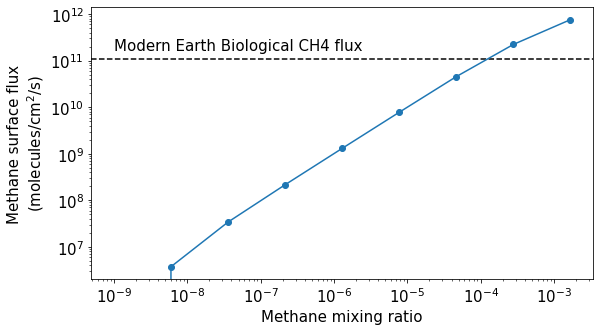

In [6]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[9,5])

ax.plot(fCH4,PhiCH4,'o-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Methane surface flux\n(molecules/cm$^2$/s)')
ax.set_xlabel('Methane mixing ratio')

bio = 1.1e11 # molecules/cm2/s
ax.axhline(y=bio,c="k",ls='--',zorder=0)
ax.text(1e-9,bio+.5*bio,'Modern Earth Biological CH4 flux')


plt.show()

I have also plotted the Modern Earth biological CH4 flux.

If biology produced about the same amount of methane in the Archean Eon, as it does in the present day, then the methane concentration might have been about ~100 ppm (1e-4).